In [1]:
print(0)

0


# IMPORTING LIBRARIES

In [2]:
import os
# used for directory manipulation and environment management

import numpy as np
# for numerical python

from PIL import Image
# opening, manipulating, and saving images

from sklearn.model_selection import train_test_split
#for splitting the data into train test val

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# for  converting labels to integers

import torch
import torch.nn as nn
# for mathematical computations

from torch.utils.data import Dataset, DataLoader, TensorDataset
# custom dataset

import torch.optim as optim

import matplotlib.pyplot as plt
# for plotting images

from sklearn.metrics import classification_report
# for rinting the basic metrics

# LOADING DATASET

In [3]:
folder_path = "/home/pratyushprasad/Desktop/GNR ASSIGNMENTS/Images"
# folder name where the images are stored

image_array = []
class_array = []
# creating empty image and class list

for class_name in os.listdir(folder_path):
    # looping through every class subfolder
    
    class_name_path = os.path.join(folder_path, class_name)    
    # location of the class folder
    
    if os.path.isdir(class_name_path):
        for image_file in os.listdir(class_name_path):
            # iterating through every imnage in the class folder
            
            image_path = os.path.join(class_name_path, image_file)
            # location of every image in the directory
            
            try:
                img = Image.open(image_path).convert("RGB")
                # opening the image
                
                img_resized = img.resize((144, 144))
                # resizing it to 256, 256 image size
                
                img_array = np.array(img_resized) / 255.0
                # scaling it 0 to 1
                
                image_array.append(img_array)
                class_array.append(class_name)
                # appending image and its class into the list
                
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

image_array = np.array(image_array)
class_array = np.array(class_array)
print(f"Loaded {len(image_array)} images with {len(class_array)} labels.")

Loaded 2100 images with 2100 labels.


# PRE-PROCESSING THE DATA

In [4]:
pool_size = 4
image_array = image_array.reshape(image_array.shape[0], image_array.shape[1] // pool_size, pool_size,
                                   image_array.shape[2] // pool_size, pool_size, image_array.shape[3])
image_array = image_array.max(axis=(2, 4))
image_array = image_array.reshape(image_array.shape[0], -1)  
print(image_array.shape)

(2100, 3888)


In [5]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(class_array)
# for class encoding

one_hot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(-1, 1)
class_array_one_hot = one_hot_encoder.fit_transform(integer_encoded)
print(class_array_one_hot.shape)

(2100, 21)


/home/pratyushprasad/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# TRAIN-TEST SPLIT

In [6]:
x_train, x_test, y_train, y_test = train_test_split(image_array, class_array_one_hot, test_size=0.3, random_state=100)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.3333, random_state=100)
# train-test-val split 70-20-10

In [7]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
# converting everything to tensors

In [8]:
batch_size = 32

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
val_dataset = TensorDataset(x_val, y_val)
# data to dataset

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# dataset to dataloader

# MODELLING

In [9]:
class StandardScalerLayer(nn.Module):
    def __init__(self, mean, std):
        super(StandardScalerLayer, self).__init__()
        self.mean = mean
        self.std = std
        
    def forward(self, x):
        return (x - self.mean) / self.std
        # data -> data-mean/variance

class PerceptronModel(nn.Module):
    def __init__(self, input_size, num_classes, mean, std):
        super(PerceptronModel, self).__init__()
        self.scalar = StandardScalerLayer(mean, std)
        self.model = nn.Sequential(
            nn.Linear(input_size, 2048),
            # LINEAR MODEL MLP (3888 TO 2048)
            nn.Dropout(0.3),
            # DROPOT OF .3 (RANDOMLY SELECTIED)
            nn.Linear(2048, 1024),
            # LINEAR MODEL MLP (2048 TO 1024)
            nn.Dropout(0.3),
            # DROPOT OF .3 (RANDOMLY SELECTIED)
            nn.Linear(1024, 256),
            # LINEAR MODEL MLP (1024 TO 256)
            nn.Linear(256, 64),
            # LINEAR MODEL MLP (256 TO 64)
            nn.Dropout(0.3),
            # DROPOT OF .3 (RANDOMLY SELECTIED)
            nn.Linear(64, num_classes)
            # LINEAR MODEL MLP (64 TO 21)
        )
        
    def forward(self, x):
        x = self.scalar(x) 
        return self.model(x)
    # FEED FORWARD NETWORK

In [10]:
input_size = 3888
# IMAGE SIZE 72 * 72

num_classes = 21
# TOTAL NUMBER OF CLASSES

mean = 0.5 * input_size
std = 0.1 * input_size
# MEAN AND STANDARD DEVIATION OF .5 AND .1 WHILE STANDARD SCALER RETRAINING

model = PerceptronModel(input_size, num_classes, mean, std)
# MODEL =  PERCETRON

criterion = nn.CrossEntropyLoss()
# CATEGORICAL CROSS ENTROPY CRITERION  WHILE WEIGHT UPDATION

optimizer = optim.Adam(model.parameters(), lr=0.002)
# OPTIMIZAR = ADAM

num_epochs = 1000
# EPOCHS  = 1000

patience = 100
# LR UPDATION PATIENCE VALUE

lr_factor = 0.5
# LR CHANGE UPDATION VALUE LR -> LR/2

best_val_loss = float('inf')
# INITIAL VAL LOSS = INDINITY

stagnant_epochs = 0

array_train_accuracy = []
array_test_accuracy = []
array_train_loss = []
array_test_loss = []
# CREATING LOSS AND ACCURACY EMPTY LISTS FOR BOTH TRAIN AND VALIDATION DATA

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_total = 0
    train_correct = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()  
        outputs = model(inputs) 
        loss = criterion(outputs, torch.argmax(labels, dim=1))  
        loss.backward() 
        train_loss += loss.item()
        optimizer.step()
        
        _, prediction_label = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (prediction_label == torch.argmax(labels, dim=1)).sum().item()
    
    model.eval()
    val_loss = 0
    val_total = 0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))  
            val_loss += loss.item()
            
            _, prediction_label = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (prediction_label == torch.argmax(labels, dim=1)).sum().item()
    
    train_accuracy = 100 * train_correct / train_total
    val_accuracy = 100 * val_correct / val_total
    
    array_train_accuracy.append(train_accuracy)
    array_test_accuracy.append(val_accuracy)
    array_train_loss.append(train_loss / len(train_loader))
    array_test_loss.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {array_train_loss[-1]:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {array_test_loss[-1]:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        stagnant_epochs = 0
    else:
        stagnant_epochs += 1
    
    if stagnant_epochs >= patience:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= lr_factor
        print(f"Reducing learning rate to {optimizer.param_groups[0]['lr']:.6f}")
        stagnant_epochs = 0

Epoch 1/1000, Train Loss: 126.9652, Train Accuracy: 4.69%, Val Loss: 24.6544, Val Accuracy: 4.29%
Epoch 2/1000, Train Loss: 27.3470, Train Accuracy: 5.65%, Val Loss: 9.5249, Val Accuracy: 1.90%
Epoch 3/1000, Train Loss: 11.0318, Train Accuracy: 4.42%, Val Loss: 6.0375, Val Accuracy: 6.19%
Epoch 4/1000, Train Loss: 5.5886, Train Accuracy: 5.10%, Val Loss: 4.5790, Val Accuracy: 6.67%
Epoch 5/1000, Train Loss: 4.5289, Train Accuracy: 5.51%, Val Loss: 4.1501, Val Accuracy: 3.81%
Epoch 6/1000, Train Loss: 4.5162, Train Accuracy: 4.76%, Val Loss: 3.9048, Val Accuracy: 3.33%
Epoch 7/1000, Train Loss: 4.1416, Train Accuracy: 4.83%, Val Loss: 3.2471, Val Accuracy: 3.33%
Epoch 8/1000, Train Loss: 3.9669, Train Accuracy: 4.42%, Val Loss: 3.1962, Val Accuracy: 5.71%
Epoch 9/1000, Train Loss: 3.9502, Train Accuracy: 3.88%, Val Loss: 3.2668, Val Accuracy: 5.24%
Epoch 10/1000, Train Loss: 3.8560, Train Accuracy: 4.01%, Val Loss: 3.2738, Val Accuracy: 7.14%
Epoch 11/1000, Train Loss: 3.8309, Train Acc

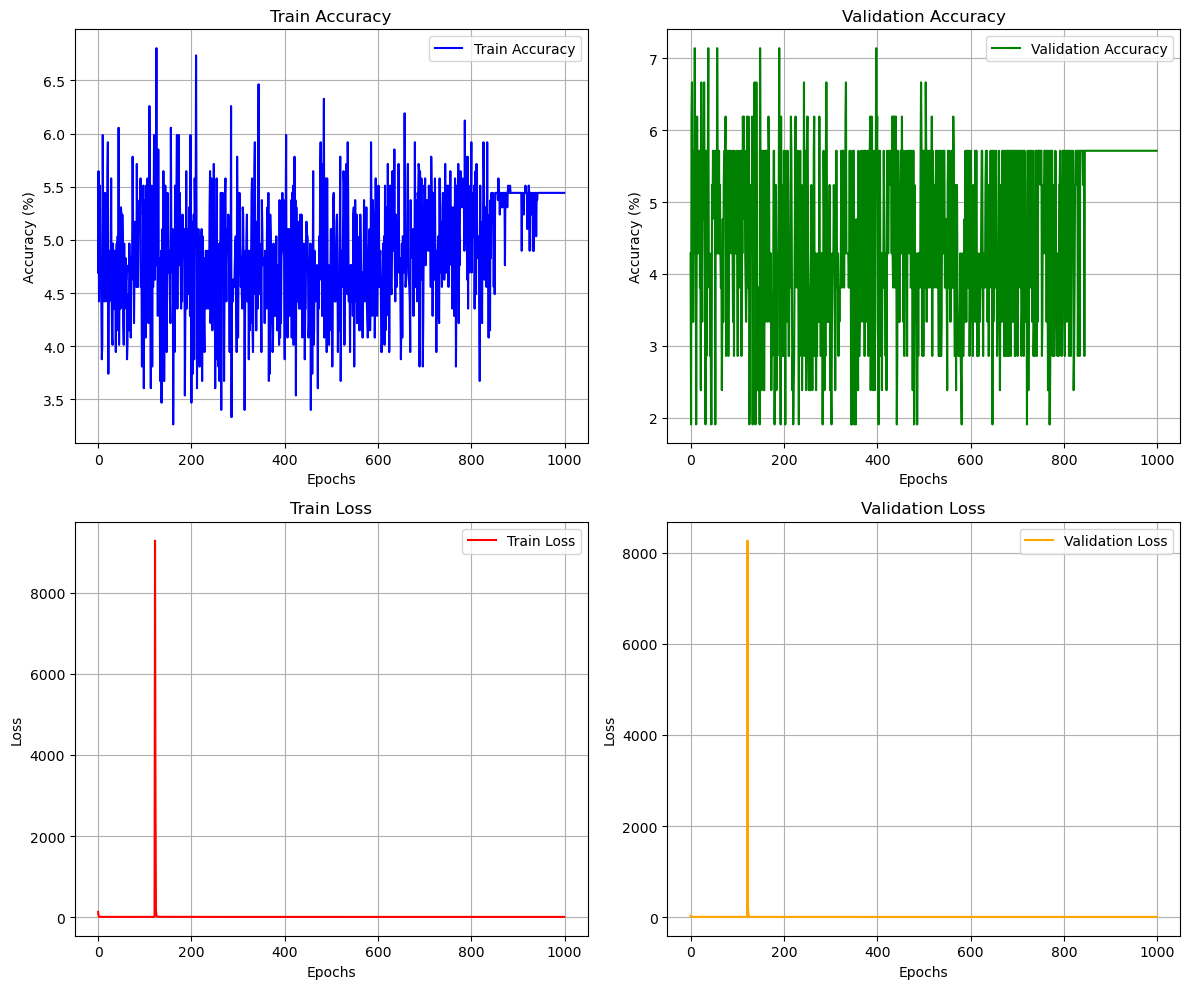

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# creating a 2 by 2 subplot image

axes[0, 0].plot(array_train_accuracy, label="Train Accuracy", color="blue")
axes[0, 0].set_title("Train Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy (%)")
axes[0, 0].legend()
axes[0, 0].grid()
# Plotting train accuracy

axes[0, 1].plot(array_test_accuracy, label="Validation Accuracy", color="green")
axes[0, 1].set_title("Validation Accuracy")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Accuracy (%)")
axes[0, 1].legend()
axes[0, 1].grid()
# Plotting validation accuracy

axes[1, 0].plot(array_train_loss, label="Train Loss", color="red")
axes[1, 0].set_title("Train Loss")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Loss")
axes[1, 0].legend()
axes[1, 0].grid()
# Plotting train loss

axes[1, 1].plot(array_test_loss, label="Validation Loss", color="orange")
axes[1, 1].set_title("Validation Loss")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].legend()
axes[1, 1].grid()
# Plotting val loss

plt.tight_layout()
plt.show()
# plotting

In [12]:
model.eval()

# Lists to store true labels and predictions
true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  
        true_labels.extend(torch.argmax(labels, dim=1).cpu().numpy()) 
        pred_labels.extend(predicted.cpu().numpy())  

# Generate the classification report
report = classification_report(true_labels, pred_labels, target_names=[f"Class {i}" for i in range(num_classes)])
print(report)


              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        17
     Class 1       0.00      0.00      0.00        24
     Class 2       0.00      0.00      0.00        15
     Class 3       0.00      0.00      0.00        20
     Class 4       0.00      0.00      0.00        15
     Class 5       0.00      0.00      0.00        14
     Class 6       0.02      1.00      0.04         8
     Class 7       0.00      0.00      0.00        23
     Class 8       0.00      0.00      0.00        27
     Class 9       0.00      0.00      0.00        27
    Class 10       0.00      0.00      0.00        19
    Class 11       0.00      0.00      0.00        25
    Class 12       0.00      0.00      0.00        23
    Class 13       0.00      0.00      0.00        25
    Class 14       0.00      0.00      0.00        27
    Class 15       0.00      0.00      0.00        17
    Class 16       0.00      0.00      0.00        17
    Class 17       0.00    

/home/pratyushprasad/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pratyushprasad/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pratyushprasad/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
